In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random
from math import sqrt

# Simple attempt to implement a variational quantum state calculation 

As an example, we start with a very simple J1/J2 Heisenberg spin chain

We define a class "model" that contains a Hamiltonian and a rule for generating spins according to the MSMS algorithm.

We have something to obtain the wavefunction amplitude $\psi_\theta(s)$ from the spin configuration $s$ that depends on some amplitude $\theta$

From  $\psi_\theta(s)$ for the given spin configuration, we can produce an estimate of the energy of the variational ground state.

Then we can perform a stochastic gradient descent based on it.

Reminder: the operators are defined as 
$$S\cdot S = S_x \cdot S_x + S_y \cdot S_y + S_z \cdot S_z = \frac{1}{2} (S_+ \cdot S_- + S_- \cdot S_+) + S_z \cdot S_z$$

where $S_z = \frac{\hbar}{2} \begin{pmatrix} 1 & 0 \\ 0  & -1 \end{pmatrix}$, $S_+ = \hbar \begin{pmatrix} 0 & 1 \\ 0 & 0 \end{pmatrix}$, $S_- = \hbar \begin{pmatrix} 0 & 0 \\ 1 & 0 \end{pmatrix}$

In [26]:
class Model:
    """
    A model that represents a 2D lattice of spins with a Hamiltonian
    """

    def __init__(self, L1, L2) -> None:
        self.L1 = L1
        self.L2 = L2
        self.Hamiltonian = np.zeros((L1, L2, L1, L2, 2, 2, 2, 2), dtype = int)

    def get_random_spins(self):
        """
        return: a 2D array (L1, L2, 2) of random spins
        Each site has either spin up [1,0] or spin down [0,1]
        """
        np.random.seed(0) #For ease of debugging, we set the seed to 0
        return np.array([[random.choice([[1, 0], [0, 1]]) for _ in range(self.L1)] for _ in range(self.L2)])
        #np.random.choice([-1, 1], size=(self.L1, self.L2))
    
    def flip_random_spin(self, spin1):
        """
        return: a 2D array (L1, L2, 2) of spins with one random spin flipped
        """
        spin2 = spin1.copy()
        i, j = random.randint(0, self.L1-1), random.randint(0, self.L2-1)
        assert spin1[i,j,0] == 0 or spin1[i,j,0] == 1, f"Invalid spin value {spin1[i,j,0]}"
        assert spin2[i,j,0] == 0 or spin2[i,j,0] == 1, f"Invalid spin value {spin2[i,j,0]}"
        spin2[i, j] = [1, 0] if spin1[i, j, 0] == 0 else [0, 1]
        return spin2

    def add_SdotS_interaction(self, r1, r2, J):
        """ 
        Add the S(r1).S(r2) interaction between spins at r1 and r2, with strength J

        The Hamiltonian represents the entries 1/2(S+(r1).S-(r2) + S-(r1).S+(r2)) + Sz(r1).Sz(r2)
        """
        self.Hamiltonian[r1[0], r1[1], r2[0], r2[1], 0, 0, 0, 0] += J/4 
        self.Hamiltonian[r1[0], r1[1], r2[0], r2[1], 0, 1, 0, 1] += -J/4 
        self.Hamiltonian[r1[0], r1[1], r2[0], r2[1], 0, 1, 1, 0] += J/2
        self.Hamiltonian[r1[0], r1[1], r2[0], r2[1], 1, 0, 1, 0] += -J/4 
        self.Hamiltonian[r1[0], r1[1], r2[0], r2[1], 1, 0, 0, 1] += J/2
        self.Hamiltonian[r1[0], r1[1], r2[0], r2[1], 1, 1, 1, 1] += J/4 

    def set_J1_Hamiltonian(self, J):
        """
        Sets the Hamiltonian to be the J1 Heisenberg model
        """
        for i in range(self.L1-1):
            for j in range(self.L2):
                self.add_SdotS_interaction((i, j), (i+1, j), J)  
                self.add_SdotS_interaction((i+1, j), (i, j), J)  
        for i in range(self.L1):
            for j in range(self.L2-1):        
                self.add_SdotS_interaction((i, j), (i, j+1), J)  
                self.add_SdotS_interaction((i, j+1), (i, j), J)      

    def set_J2_Hamiltonian(self, J):
        """
        Sets the Hamiltonian to be the J2 Heisenberg model
        """
        for i in range(self.L1-1):
            for j in range(self.L2-1):
                self.add_SdotS_interaction((i, j), (i+1, j+1), J)  
        for i in range(self.L1):
            for j in range(self.L2-1):        
                self.add_SdotS_interaction((i+1, j), (i, j+1), J)           

    def Hdot(self, spin1, spin2):
        """
        #get the Hamiltonian expectation value <spin1|H|spin2>
        #where spin1 and spin2 are 2D arrays (L1, L2) generated by get_random_spins or equivalent
        """
        assert spin1.dtype == int, f"Hdot cannot handle spins of type {spin1.dtype}. Please convert this to int"
        assert np.all(np.sum(spin1, axis = -1) == 1), "spin1 is not properly normalized"
        assert np.all(np.sum(spin2, axis = -1) == 1), "spin1 is not properly normalized"
        result = np.einsum('ija,klb,ijc,kld,ijklabcd->', spin1, spin1, spin2, spin2, self.Hamiltonian)
        return result
    
    def vdot(self, spin1, spin2):
        """
        #get the overlap expectation value <spin1|spin2>
        #where spin1 and spin2 are 2D arrays (L1, L2) generated by get_random_spins or equivalent
        """
        assert spin1.dtype == int, f"Hdot cannot handle spins of type {spin1.dtype}. Please convert this to int"
        assert np.all(np.sum(spin1, axis = -1) == 1), "spin1 is not properly normalized"
        assert np.all(np.sum(spin2, axis = -1) == 1), "spin1 is not properly normalized"
        result = np.einsum('ija,ija->', spin1, spin2)
        return result

    def reset_Hamiltonian(self):
        #sets the Hamiltonian to zero-for debugging purpose
        self.Hamiltonian = np.zeros((self.L1, self.L2, self.L1, self.L2, 2, 2, 2, 2))
        
    def get_Hamiltonian(self):
        #returns the Hamiltonian—for debugging purpose
        return self.Hamiltonian
    

## Miscellaneous sanity checks

### Verifying that the Hamiltonian evaluated onto spins give sensible results

In [31]:
test = Model(2, 1)
spin1 = np.array([[[1,0] for _ in range(test.L2)] for _ in range(test.L1)])
spin2 = np.array([[[1,0] for _ in range(test.L2)] for _ in range(test.L1)])
print(f"Hamiltonian is empty: <spin1|H|spin2>={test.Hdot(spin1, spin2)}")
test.reset_Hamiltonian()
test.set_J1_Hamiltonian(1)
print(f"J1 Hamiltonian gives: <spin1|H|spin2>={test.Hdot(spin1, spin2)}")
spin2[1, 0] = [0,1]
print(f"Flipping a spin in s Hamiltonian gives: <spin1|H|spin2>={test.Hdot(spin1, spin2)}")
#Consider a singlet state
spinud = spin1.copy()
spinud[1, 0] = [0, 1]
spindu = spin1.copy()
spindu[0, 0] = [0, 1]
singlet_energy = (test.Hdot(spinud, spinud)-test.Hdot(spindu, spinud)-test.Hdot(spinud, spindu)+test.Hdot(spindu, spindu))#/2
triplet_energy = (test.Hdot(spinud, spinud)+test.Hdot(spindu, spinud)+test.Hdot(spinud, spindu)+test.Hdot(spindu, spindu))#/2
print(f"J1 Hamiltonian on singlet state gives: <spin1|H|spin2>={singlet_energy}")
print(f"J1 Hamiltonian on triplet state gives: <spin1|H|spin2>={triplet_energy}")

Hamiltonian is empty: <spin1|H|spin2>=0
J1 Hamiltonian gives: <spin1|H|spin2>=0.5
Flipping a spin in s Hamiltonian gives: <spin1|H|spin2>=0.0
J1 Hamiltonian on singlet state gives: <spin1|H|spin2>=-3.0
J1 Hamiltonian on triplet state gives: <spin1|H|spin2>=1.0


In [29]:
test = Model(4, 4)
spin1 = np.array([[[1,0] for _ in range(test.L2)] for _ in range(test.L1)])
spin2 = np.array([[[1,0] for _ in range(test.L2)] for _ in range(test.L1)])
print(f"Hamiltonian is empty: <spin1|H|spin2>={test.Hdot(spin1, spin2)}")
test.reset_Hamiltonian()
test.set_J1_Hamiltonian(1)
print(f"J1 Hamiltonian gives: <spin1|H|spin2>={test.Hdot(spin1, spin2)}")
spin2[0,0] = [0, 1]
print(f"Flipping a corner spin in s Hamiltonian gives: <spin1|H|spin2>={test.Hdot(spin1, spin2)}")
spin2[2,2] = [0, 1]
print(f"Flipping a middle spin in s Hamiltonian gives: <spin1|H|spin2>={test.Hdot(spin1, spin2)}")

Hamiltonian is empty: <spin1|H|spin2>=0
J1 Hamiltonian gives: <spin1|H|spin2>=12.0
Flipping a corner spin in s Hamiltonian gives: <spin1|H|spin2>=11.0
Flipping a middle spin in s Hamiltonian gives: <spin1|H|spin2>=9.0


### Generating random spins

In [27]:
test = Model(4, 4)
test.get_random_spins()

array([[[1, 0],
        [0, 1],
        [1, 0],
        [1, 0]],

       [[0, 1],
        [1, 0],
        [1, 0],
        [1, 0]],

       [[1, 0],
        [0, 1],
        [0, 1],
        [1, 0]],

       [[1, 0],
        [1, 0],
        [1, 0],
        [0, 1]]])

### Plotting out the adjacency elements of the J1 hamiltonian

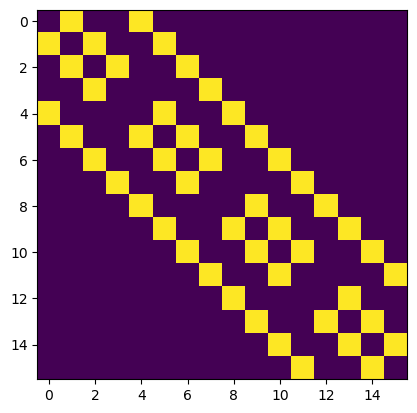

In [28]:
test = Model(4, 4)
test.reset_Hamiltonian()
test.set_J1_Hamiltonian(1)
np.linalg.norm(test.get_Hamiltonian())
plt.imshow(np.sum(test.get_Hamiltonian().reshape(16, 16, 16), axis = -1))

# Pseudocode


After having a class of spin and Hamiltonian, consider a wavefunction object, take takes a spin and returns a number

The object would be an NN (most basic example includes the Carleo RBM, which actually has an analytical form)

Sampling the spins would involve taking some dot product. 

I need a function to compute the variational energy. A function to give gradient. And a function to do the gradient descent.

Reminder: the variational quantum state is defined as (here $h_1, \dots, h_M$ represents some auxillary spin variables)

\begin{align*}
\Psi_M(S;W) = \sum_{h_i} e^{\sum_j a_j \sigma^z_j + \sum_i b_i h_i + \sum_{ij} W_{ij} h_i \sigma^{z}_j}
\end{align*}

In [ ]:
class RBM:
    """
    A reduced Boltzmann machine that implements the spin wavefunction based on the model class
    """
    def __init__(self, model) -> None:
        self.model = model
        self.L1 = model.L1
        self.L2 = model.L2
        self.M = int(self.L1*self.L2/2)

## Whatever (the irreversible trash heap)

In [ ]:
#Old definition of the model. Pending removal

class Model:
    def __init__(self, L1, L2) -> None:
        self.L1 = L1
        self.L2 = L2
        self.Hamiltonian = np.zeros((L1, L2, L1, L2, 4, 4))

    def get_random_spins(self):
        #return a 2D array (L1, L2) of random spins
        #Each site has either spin up [1,0] or spin down [0,1]
        np.random.seed(0) #For ease of debugging, we set the seed to 0
        return np.array([[random.choice([[1, 0], [0, 1]]) for _ in range(self.L1)] for _ in range(self.L2)])
        #np.random.choice([-1, 1], size=(self.L1, self.L2))
    

    def add_SdotS_interaction(self, r1, r2,J):
        #Add the S(r1).S(r2) interaction between spins at r1 and r2, with strength J
        self.Hamiltonian[r1[0], r1[1], r2[0], r2[1]] += J*np.array([[1/4, 0, 0, 0], 
                                                                    [0, -1/4, 1/2, 0],
                                                                    [0, 1/2, -1/4, 0],
                                                                    [0, 0, 0, 1/4]])

    def set_J1_Hamiltonian(self, J):
        #Sets the Hamiltonian to be the J1 Heisenberg model
        for i in range(self.L1-1):
            for j in range(self.L2):
                self.add_SdotS_interaction((i, j), (i+1, j), J)
                #self.add_SdotS_interaction((i+1, j), (i, j), J)    
        for i in range(self.L1):
            for j in range(self.L2-1):        
                self.add_SdotS_interaction((i, j), (i, j+1), J) 
                #self.add_SdotS_interaction((i, j+1), (i, j), J)            

    def mdot(self, spin1, spin2):
        #get the Hamiltonian expectation value <spin1|H|spin2>
        #where spin1 and spin2 are 2D arrays (L1, L2) generated by get_random_spins or equivalent
        result = 0
        for i in range(self.L1):
            for j in range(self.L2):
                for k in range(self.L1):
                    for l in range(self.L2):
                        #print(f"i = {i}, j = {j}, k = {k}, l = {l}, spin1[i,j] = {spin1[i,j]}, spin2[k,l] = {spin2[k,l]}, result = {result}")
                        if spin1[i, j ,0] == 1  and spin1[k,l,0] == 1 :
                            if spin2[i,j,0] == 1 and spin2[k,l,0] == 1 :
                                result += self.Hamiltonian[i, j, k, l, 0, 0]
                        if spin1[i, j,0] == 1  and spin1[k,l,1] == 1 :
                            if spin2[i,j,0] == 1  and spin2[k,l,1] == 1 :
                                result += self.Hamiltonian[i, j, k, l, 1, 1]
                            if spin2[i,j,1] == 1  and spin2[k,l,0] == 1 :
                                result += self.Hamiltonian[i, j, k, l, 1, 2]
                        if spin1[i, j,1] == 1  and spin1[k,l,0] == 1:
                            if spin2[i,j,0] == 1  and spin2[k,l,1] == 1:
                                result += self.Hamiltonian[i, j, k, l, 2, 1]
                            if spin2[i,j,1] == 1  and spin2[k,l,0] == 1 :
                                result += self.Hamiltonian[i, j, k, l, 2, 2]
                        if spin1[i, j,1] == 1  and spin1[k,l,1] == 1 :
                            if spin2[i,j,1] == 1 and spin2[k,l,1] == 1 :
                                result += self.Hamiltonian[i, j, k, l, 3, 3]
        return result
        #return np.einsum('ijklmn,ijm,kln->', self.Hamiltonian, spin1, spin2)

    def reset_Hamiltonian(self):
        #sets the Hamiltonian to zero-for debugging purpose
        self.Hamiltonian = np.zeros((self.L1, self.L2, self.L1, self.L2, 4, 4))
        
    def get_Hamiltonian(self):
        #returns the Hamiltonian—for debugging purpose
        return self.Hamiltonian
    
